# Splines in PyMC3

- [Question](https://discourse.pymc.io/t/spline-regression-in-pymc3/6235) on PyMC Discourse
- *Statistical Rethinking* example in [PyMC3](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_04.ipynb) and [Stan](https://vincentarelbundock.github.io/rethinking2/04.html)
- My [post](https://joshuacook.netlify.app/post/pymc3-spline/) with additional visualization and explination

In [1]:
import string
import warnings
from pathlib import Path

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
from patsy import dmatrix
from theano import tensor as tt

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")
rethinking_data_path = Path("../data/rethinking_data")
modeling_data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
modeling_data2_path = Path("../modeling_data/depmap_modeling_dataframe_subsample2.csv")

## Replicate the example from *Statistical Rethinking*

In [2]:
d = pd.read_csv(rethinking_data_path / "cherry_blossoms.csv")
# nans are not treated as in the book
az.summary(d.dropna().to_dict(orient="list"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
year,1533.395,291.123,1016.00,1978.00
doy,104.921,6.258,92.00,115.00
temp,6.100,0.683,4.80,7.32
temp_upper,6.938,0.812,5.56,8.40
temp_lower,5.264,0.762,3.75,6.83


In [3]:
d2 = d.dropna(subset=["doy"]).reset_index(drop=True)
d2.head(n=10)

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.10,2.66
4,853,104.0,NaN,NaN,NaN
5,864,100.0,6.42,8.69,4.14
6,866,106.0,6.44,8.11,4.77
7,869,95.0,NaN,NaN,NaN
8,889,104.0,6.83,8.48,5.19
9,891,109.0,6.98,8.96,5.00


In [4]:
d2.shape

(827, 5)

In [5]:
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

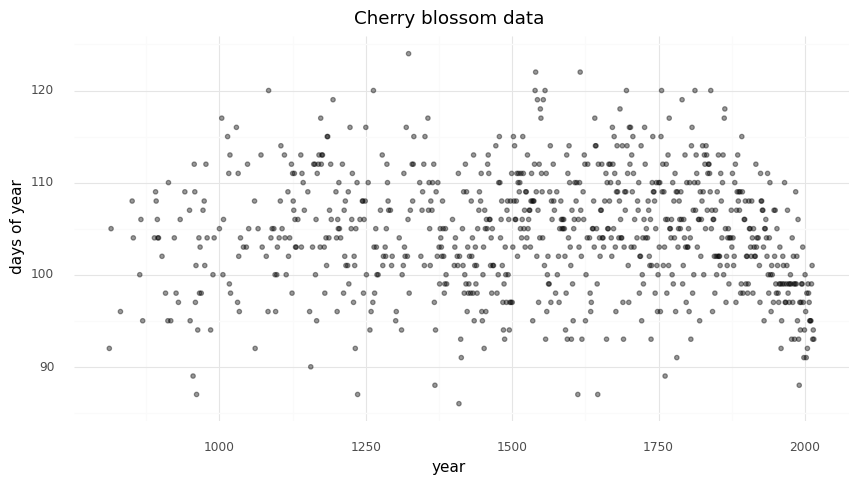

<ggplot: (8749127536595)>

In [6]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data")
)

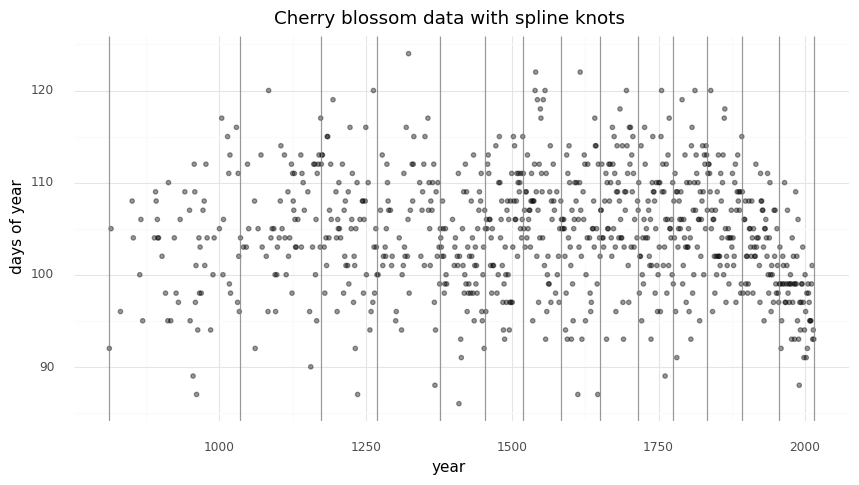

<ggplot: (8749166099776)>

In [7]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data with spline knots")
)

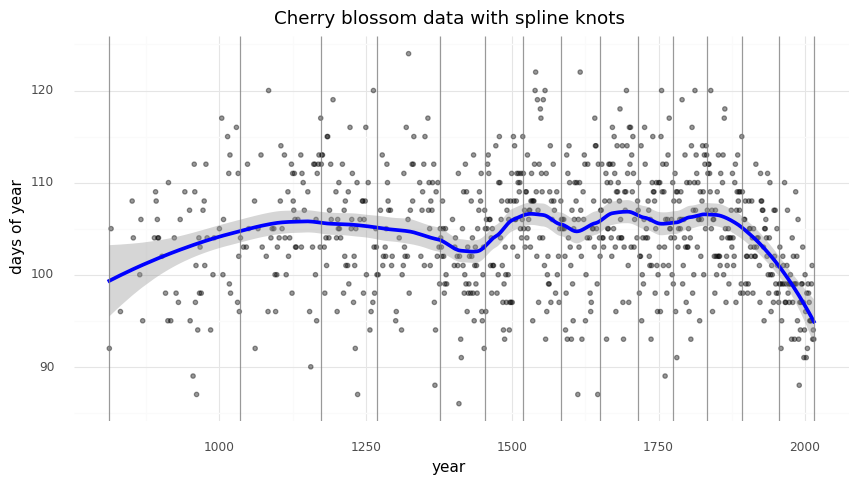

<ggplot: (8749126939763)>

In [8]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.geom_smooth(method="loess", span=0.3, size=1.5, color="blue", linetype="-")
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data with spline knots")
)

In [9]:
d2["knot_group"] = [np.where(a <= knot_list)[0][0] for a in d2.year]
d2["knot_group"] = pd.Categorical(d2["knot_group"], ordered=True)

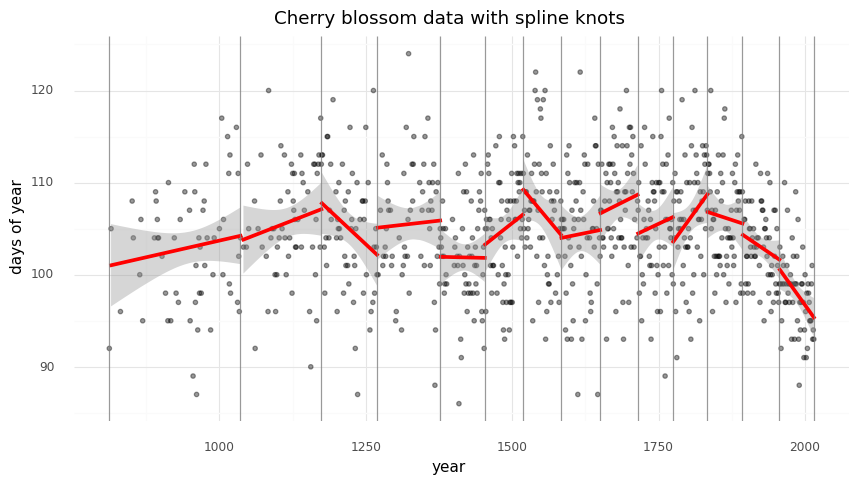

<ggplot: (8749127536553)>

In [10]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.geom_smooth(
        gg.aes(group="knot_group"), method="lm", size=1.5, color="red", linetype="-"
    )
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data with spline knots")
)

In [11]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

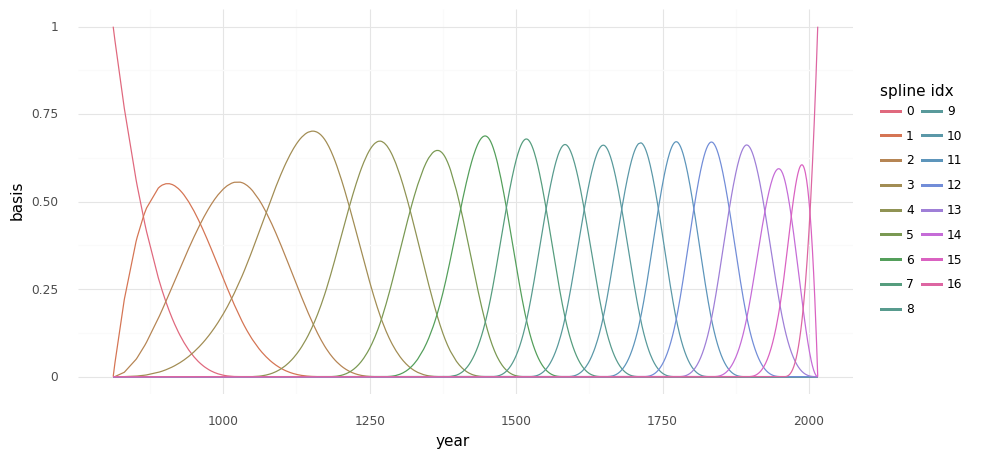

<ggplot: (8749126940468)>

In [12]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=d2.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(spline_df, gg.aes(x="year", y="value"))
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"))
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2), color_space="husl")
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="basis", color="spline idx")
)

In [13]:
with pm.Model() as m4_7:
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu=0, sd=3, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)

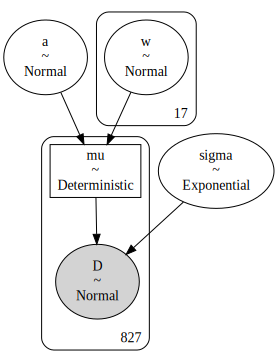

In [14]:
pm.model_to_graphviz(m4_7)

In [15]:
with m4_7:
    prior_pc = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    trace_m4_7 = pm.sample(2000, tune=2000, random_seed=RANDOM_SEED, chains=2)
    post_pc = pm.sample_posterior_predictive(trace_m4_7, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.70487961130992, but should be close to 0.8. Try to increase the number of tuning steps.


In [16]:
az_m4_7 = az.from_pymc3(
    model=m4_7, trace=trace_m4_7, posterior_predictive=post_pc, prior=prior_pc
)

In [17]:
az.summary(az_m4_7, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,103.620,0.764,102.131,105.028,0.019,0.014,1552.0,1552.0,1557.0,1786.0,1.0
w[0],-1.783,2.233,-5.919,2.496,0.041,0.035,2905.0,2071.0,2925.0,2491.0,1.0
w[1],-1.563,2.099,-5.652,2.242,0.040,0.029,2704.0,2588.0,2699.0,2649.0,1.0
w[2],-0.269,1.898,-3.956,3.179,0.040,0.032,2252.0,1747.0,2254.0,2232.0,1.0
w[3],3.412,1.483,0.622,6.140,0.033,0.024,2017.0,1903.0,2017.0,2268.0,1.0
w[4],0.182,1.498,-2.734,2.939,0.032,0.022,2246.0,2246.0,2256.0,2508.0,1.0
w[5],2.147,1.598,-0.934,5.068,0.031,0.023,2723.0,2364.0,2721.0,2360.0,1.0
w[6],-3.533,1.484,-6.309,-0.774,0.030,0.021,2517.0,2393.0,2513.0,2494.0,1.0
w[7],5.566,1.504,2.722,8.346,0.031,0.022,2416.0,2382.0,2415.0,2594.0,1.0
w[8],-0.014,1.575,-2.908,3.064,0.030,0.023,2681.0,2333.0,2678.0,2782.0,1.0


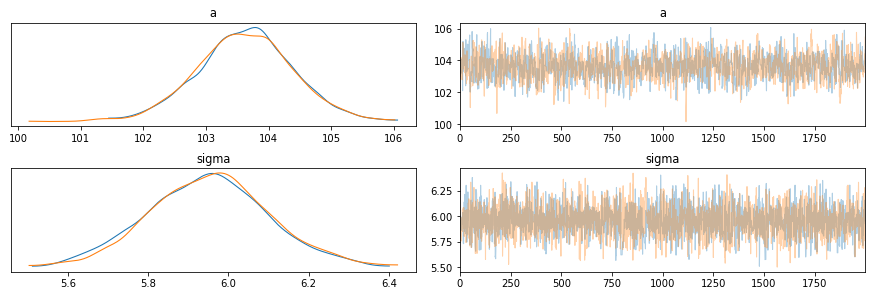

In [18]:
az.plot_trace(az_m4_7, var_names=["a", "sigma"])
plt.show()

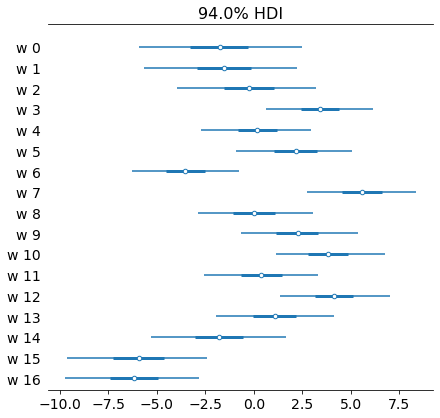

In [19]:
az.plot_forest(az_m4_7, var_names=["w"], combined=True)
plt.show()

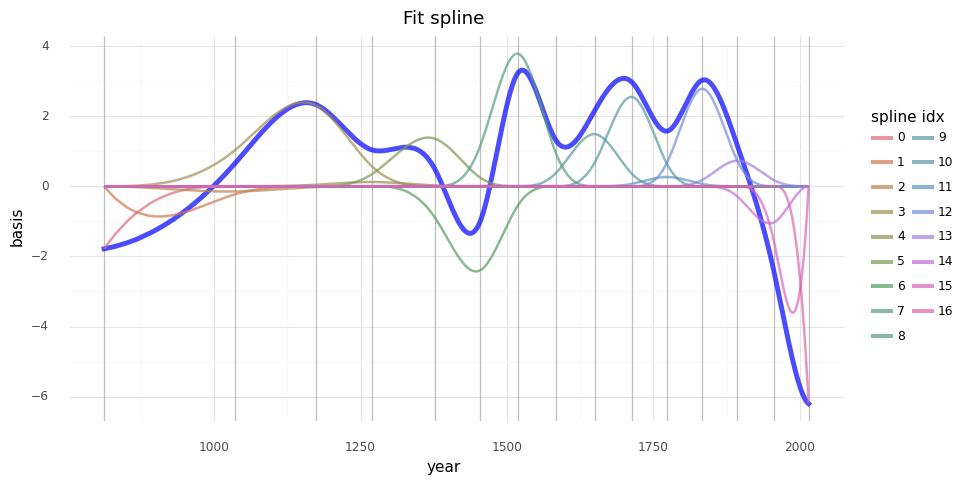

<ggplot: (8749125268255)>

In [20]:
wp = trace_m4_7["w"].mean(0)

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(year=d2.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(year=d2.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(spline_df, gg.aes(x="year", y="value"))
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.5)
    + gg.geom_line(data=spline_df_merged, linetype="-", color="blue", size=2, alpha=0.7)
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"), alpha=0.7, size=1)
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2), color_space="husl")
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="basis", title="Fit spline", color="spline idx")
)

In [21]:
post_pred = az.summary(az_m4_7, var_names=["mu"]).reset_index(drop=True)
d2_post = d2.copy().reset_index(drop=True)
d2_post["pred_mean"] = post_pred["mean"]
d2_post["pred_hdi_lower"] = post_pred["hdi_3%"]
d2_post["pred_hdi_upper"] = post_pred["hdi_97%"]

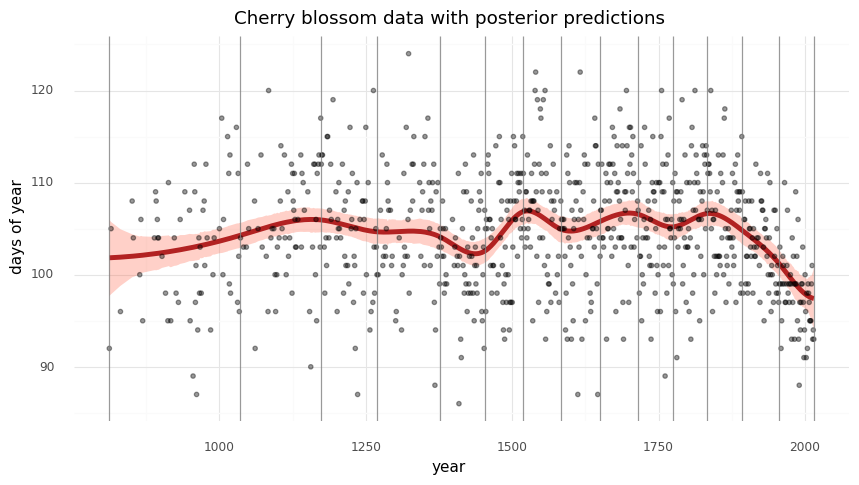

<ggplot: (8749091940660)>

In [22]:
(
    gg.ggplot(d2_post, gg.aes(x="year"))
    + gg.geom_ribbon(
        gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato"
    )
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.geom_point(gg.aes(y="doy"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(
        x="year",
        y="days of year",
        title="Cherry blossom data with posterior predictions",
    )
)

## Example with gene CN data of a single gene

In [23]:
modeling_data = pd.read_csv(modeling_data_path)
modeling_data.head(n=7)

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,AAGAGGCCGGTCAAATTCAG,42-mg-ba-311cas9_repa_p6_batch3,-0.405499,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.845287,1.328646,0,False,NaN,NaN,NaN,NaN,False,1.263034
1,AATCAACCCACAGCTGCACA,42-mg-ba-311cas9_repa_p6_batch3,-0.133541,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.827398,1.287359,2,False,missense_mutation;missense_mutation,FALSE;FALSE,TRUE;TRUE,TRUE;TRUE,False,5.220330
2,AATTACTACTTGCTTCCTGT,42-mg-ba-311cas9_repa_p6_batch3,-0.491495,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.879280,1.409165,0,False,NaN,NaN,NaN,NaN,False,3.008989
3,ACCTGTATGACGAAACCGTG,42-mg-ba-311cas9_repa_p6_batch3,-0.015850,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
4,ACTCTGTTCCTTCATCTCCG,42-mg-ba-311cas9_repa_p6_batch3,-0.530277,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.990378,1.692253,0,False,NaN,NaN,NaN,NaN,False,5.822730
5,ACTGCTGCGGGAATTCCAAG,42-mg-ba-311cas9_repa_p6_batch3,0.778827,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
6,AGACACTTATACTATGAAAG,42-mg-ba-311cas9_repa_p6_batch3,0.035950,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.872323,1.392463,0,False,NaN,NaN,NaN,NaN,False,3.701549


### A "well-behaved" gene: *PTK2*

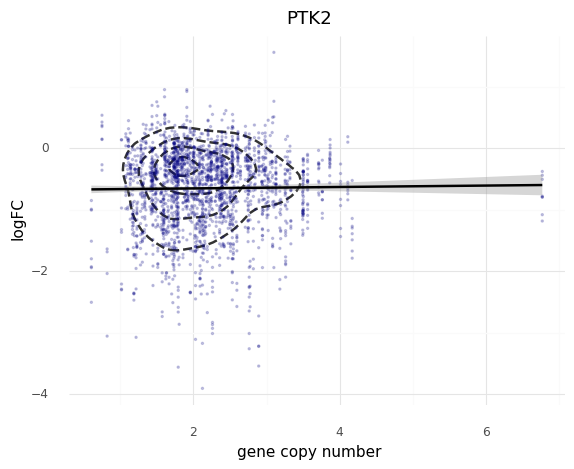

<ggplot: (8749092018815)>

In [24]:
np.random.seed(RANDOM_SEED)
ptk2_data = modeling_data[modeling_data.hugo_symbol == "PTK2"]

(
    gg.ggplot(ptk2_data, gg.aes(x="gene_cn", y="lfc"))
    + gg.geom_density_2d(color="black", alpha=0.8, size=1, linetype="--")
    + gg.geom_point(size=0.4, alpha=0.2, color="navy")
    + gg.geom_smooth(method="lm")
    + gg.labs(x="gene copy number", y="logFC", title="PTK2")
)

In [25]:
ptk2_data.shape[0]

2332

In [26]:
cn_num_knots = 5
cn_knot_list = np.quantile(ptk2_data.gene_cn, np.linspace(0, 1, cn_num_knots))

ptk2_B = dmatrix(
    "bs(x, knots=knots, degree=3, include_intercept=True) - 1",
    {"x": ptk2_data.gene_cn, "knots": cn_knot_list[1:-1]},
)

print(cn_knot_list)

[0.60396783 1.67270427 2.08756486 2.53427991 6.7709577 ]


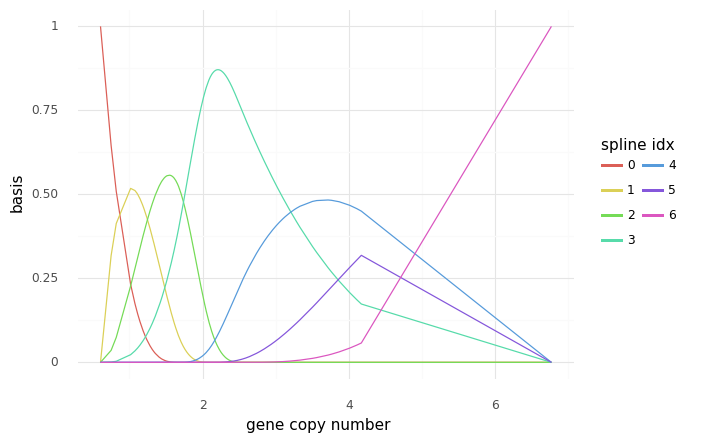

<ggplot: (8749091940765)>

In [27]:
ptk2_spline_df = (
    pd.DataFrame(ptk2_B)
    .assign(gene_cn=ptk2_data.gene_cn.values)
    .melt("gene_cn", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(ptk2_spline_df, gg.aes(x="gene_cn", y="value"))
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"))
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2))
    + gg.labs(x="gene copy number", y="basis", color="spline idx")
)

In [28]:
with pm.Model() as m_ptk2:
    a = pm.Normal("a", mu=0, sd=2)
    w = pm.Normal("w", mu=-0.5, sd=1, shape=ptk2_B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(ptk2_B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=ptk2_data.lfc)

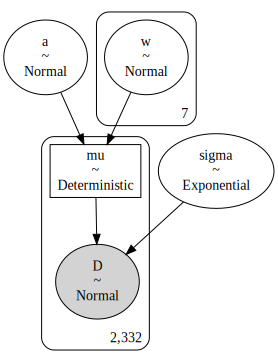

In [29]:
pm.model_to_graphviz(m_ptk2)

In [30]:
with m_ptk2:
    prior_pc = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    trace_m_ptk2 = pm.sample(3000, tune=2000, chains=2, random_seed=RANDOM_SEED)
    post_pc = pm.sample_posterior_predictive(trace_m_ptk2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 58 seconds.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [31]:
az_ptk2 = az.from_pymc3(
    model=m_ptk2, trace=trace_m_ptk2, posterior_predictive=post_pc, prior=prior_pc
)

In [32]:
post_pred = az.summary(az_ptk2, var_names=["mu"]).reset_index(drop=True)
ptk2_post = ptk2_data.copy().reset_index(drop=True)
ptk2_post["pred_mean"] = post_pred["mean"]
ptk2_post["pred_hdi_lower"] = post_pred["hdi_3%"]
ptk2_post["pred_hdi_upper"] = post_pred["hdi_97%"]
ptk2_post.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,pred_mean,pred_hdi_lower,pred_hdi_upper
0,ATATGGCTGACCTAATAGAT,42-mg-ba-311cas9_repa_p6_batch3,-0.723507,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,5.878235,-0.645,-0.685,-0.605
1,CGATCATACTGGGAGATGCG,42-mg-ba-311cas9_repa_p6_batch3,-0.445568,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,5.878235,-0.645,-0.685,-0.605
2,GCGAGGTTCCATTCACCAGC,42-mg-ba-311cas9_repa_p6_batch3,-0.429098,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,5.878235,-0.645,-0.685,-0.605
3,GGAGGTTCACTGGCTTCACG,42-mg-ba-311cas9_repa_p6_batch3,-0.485250,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,5.878235,-0.645,-0.685,-0.605
4,ATATGGCTGACCTAATAGAT,42-mg-ba-311cas9_repb_p6_batch3,-0.889930,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,False,NaN,NaN,NaN,NaN,False,5.878235,-0.645,-0.685,-0.605


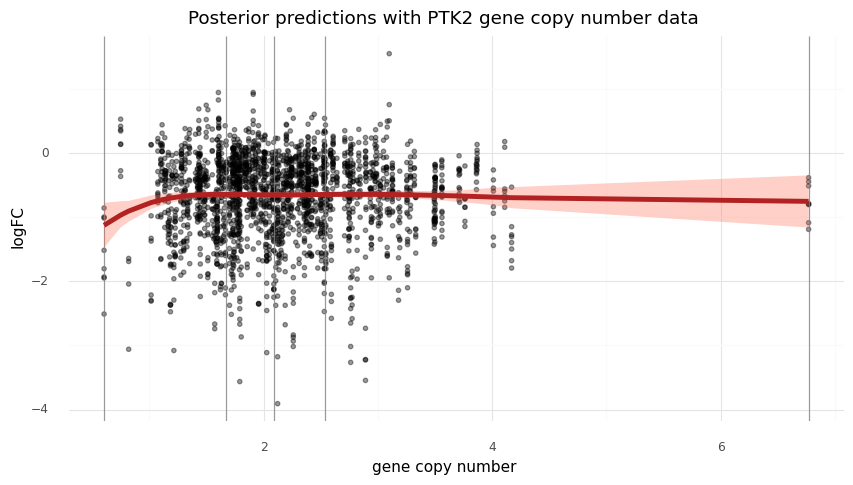

<ggplot: (8749092142403)>

In [33]:
(
    gg.ggplot(ptk2_post, gg.aes(x="gene_cn"))
    + gg.geom_point(gg.aes(y="lfc"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=cn_knot_list, color="gray", alpha=0.8)
    + gg.geom_ribbon(
        gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato"
    )
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(
        x="gene copy number",
        y="logFC",
        title="Posterior predictions with PTK2 gene copy number data",
    )
)

### A "misbehaved" gene: *MDM2*

In the original Meyers *et al.* (2017) paper, the spline function for each cell line was created with 25 slope coefficients.
The first was automatically pinned to copy number = 0 and the rest were determed using average linkage clustering (a form a hierarhcical clustering) of copy number data for each cell line.
I want to mimic this effect here, but will use the copy number data of all of the genes in the modeling data sub-sample to determine the knots and then fit the model with the data from *MDM2*, a gene was some strong extemes for copy number.

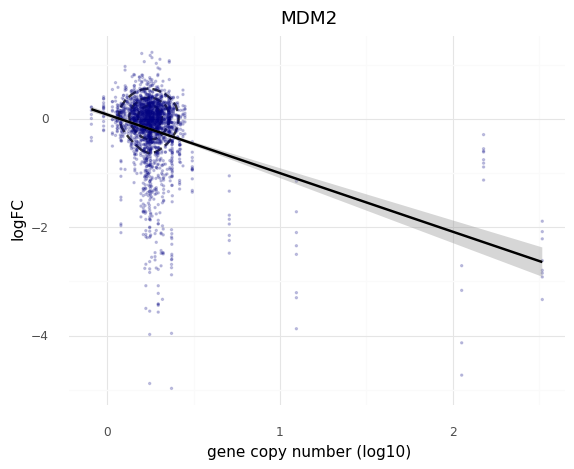

<ggplot: (8749092142400)>

In [34]:
np.random.seed(RANDOM_SEED)
mdm2_data = modeling_data.copy()[modeling_data.hugo_symbol == "MDM2"]
mdm2_data["log_gene_cn"] = np.log10(mdm2_data.gene_cn.values)
(
    gg.ggplot(mdm2_data, gg.aes(x="log_gene_cn", y="lfc"))
    + gg.geom_density_2d(color="black", alpha=0.8, size=1, linetype="--")
    + gg.geom_point(size=0.4, alpha=0.2, color="navy")
    + gg.geom_smooth(method="lm")
    + gg.labs(x="gene copy number (log10)", y="logFC", title="MDM2")
)

In [35]:
mdm2_data.shape[0]

2332

In [36]:
cn_num_knots = 5
gene_cn_data = (
    modeling_data[["depmap_id", "hugo_symbol", "gene_cn"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
cn_knot_list = np.quantile(gene_cn_data.gene_cn, np.linspace(0, 1, cn_num_knots))

mdm2_B = dmatrix(
    "bs(x, knots=knots, degree=3, include_intercept=True) - 1",
    {"x": mdm2_data.gene_cn, "knots": cn_knot_list[1:-1]},
)

print([np.round(a, 2) for a in cn_knot_list])

[0.0, 1.44, 1.73, 2.03, 328.39]


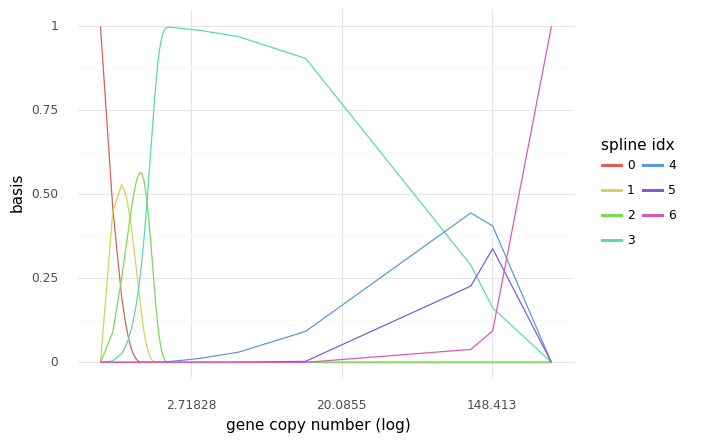

<ggplot: (8749118253445)>

In [37]:
mdm2_spline_df = (
    pd.DataFrame(mdm2_B)
    .assign(gene_cn=mdm2_data.gene_cn.values)
    .melt("gene_cn", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(mdm2_spline_df, gg.aes(x="gene_cn", y="value"))
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"))
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2))
    + gg.scale_x_continuous(trans="log")
    + gg.labs(x="gene copy number (log)", y="basis", color="spline idx")
)

In [38]:
with pm.Model() as m_mdm2:
    a = pm.Normal("a", mu=0, sd=2)
    w = pm.Normal("w", mu=-0.5, sd=1, shape=mdm2_B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(mdm2_B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=mdm2_data.lfc)

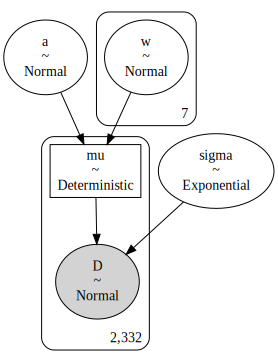

In [39]:
pm.model_to_graphviz(m_mdm2)

In [40]:
with m_mdm2:
    prior_pc = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    trace_m_mdm2 = pm.sample(3000, tune=3000, chains=2, random_seed=RANDOM_SEED)
    post_pc = pm.sample_posterior_predictive(trace_m_mdm2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, w, a]


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 81 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [41]:
az_mdm2 = az.from_pymc3(
    model=m_mdm2, trace=trace_m_mdm2, posterior_predictive=post_pc, prior=prior_pc
)

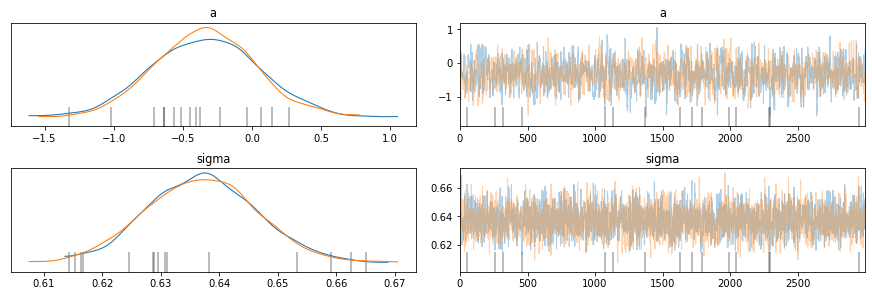

In [42]:
az.plot_trace(az_mdm2, var_names=["a", "sigma"])
plt.show()

In [43]:
post_pred = az.summary(az_mdm2, var_names=["mu"]).reset_index(drop=True)
mdm2_post = mdm2_data.copy().reset_index(drop=True)
mdm2_post["pred_mean"] = post_pred["mean"]
mdm2_post["pred_hdi_lower"] = post_pred["hdi_3%"]
mdm2_post["pred_hdi_upper"] = post_pred["hdi_97%"]
mdm2_post.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log_gene_cn,pred_mean,pred_hdi_lower,pred_hdi_upper
0,AGACACTTATACTATGAAAG,42-mg-ba-311cas9_repa_p6_batch3,0.035950,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,NaN,NaN,NaN,NaN,False,3.701549,0.143784,0.003,-0.053,0.058
1,AGTTACTGTGTATCAGGCAG,42-mg-ba-311cas9_repa_p6_batch3,0.059690,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,NaN,NaN,NaN,NaN,False,3.701549,0.143784,0.003,-0.053,0.058
2,GTTCTTGTCCTTCTTCACTA,42-mg-ba-311cas9_repa_p6_batch3,0.148150,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,NaN,NaN,NaN,NaN,False,3.701549,0.143784,0.003,-0.053,0.058
3,TTGCAATGTGATGGAAGGGG,42-mg-ba-311cas9_repa_p6_batch3,-0.102953,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,NaN,NaN,NaN,NaN,False,3.701549,0.143784,0.003,-0.053,0.058
4,AGACACTTATACTATGAAAG,42-mg-ba-311cas9_repb_p6_batch3,-0.469799,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,NaN,NaN,NaN,NaN,False,3.701549,0.143784,0.003,-0.053,0.058


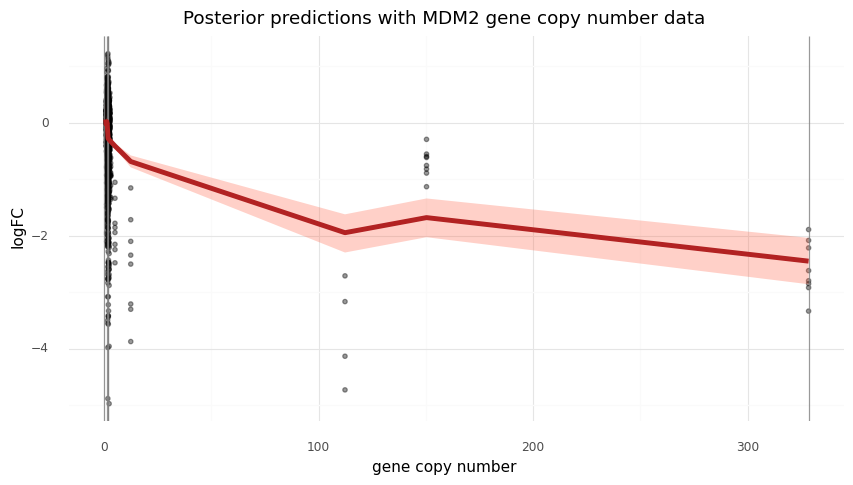

<ggplot: (8749118234242)>

In [44]:
(
    gg.ggplot(mdm2_post, gg.aes(x="gene_cn"))
    + gg.geom_point(gg.aes(y="lfc"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=cn_knot_list, color="gray", alpha=0.8)
    + gg.geom_ribbon(
        gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato"
    )
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.theme(figure_size=(10, 5))
    + gg.scale_x_continuous()
    + gg.labs(
        x="gene copy number",
        y="logFC",
        title="Posterior predictions with MDM2 gene copy number data",
    )
)

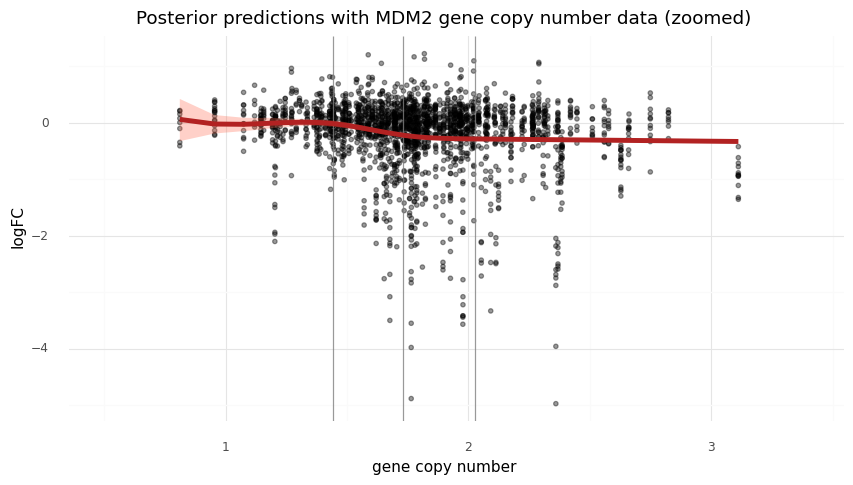

<ggplot: (8749103721328)>

In [45]:
(
    gg.ggplot(mdm2_post, gg.aes(x="gene_cn"))
    + gg.geom_point(gg.aes(y="lfc"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=cn_knot_list, color="gray", alpha=0.8)
    + gg.geom_ribbon(
        gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato"
    )
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.theme(figure_size=(10, 5))
    + gg.scale_x_continuous(limits=(0.5, 3.4))
    + gg.labs(
        x="gene copy number",
        y="logFC",
        title="Posterior predictions with MDM2 gene copy number data (zoomed)",
    )
)

### Multi-level

How to do this with multiple levels?
The original 2017 paper created a spline function for each cell line.
I think the only change would be to have an additional index on `w` and keep all of the `B` matrices in a list that gets indexed, too.

In [51]:
modeling_data2 = pd.read_csv(modeling_data2_path)

for col in ["depmap_id", "hugo_symbol", "sgrna"]:
    modeling_data2[col] = pd.Categorical(modeling_data2[col], ordered=True)

modeling_data2.head(n=7)

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,AAAACCCAGGAAATTAGCAA,dkmg-311cas9_repa_p5_batch3,0.205242,3,True,ACH-000244,Primary,central_nervous_system,glioma,WT,...,1.010773,1.747725,0,False,NaN,NaN,NaN,NaN,False,6.130931
1,AAAAGTCCACCAGAGCCATG,dkmg-311cas9_repa_p5_batch3,-0.079548,3,True,ACH-000244,Primary,central_nervous_system,glioma,WT,...,0.988893,1.688256,0,False,NaN,NaN,NaN,NaN,False,0.000000
2,AAACAACTATCATGAGCGCG,dkmg-311cas9_repa_p5_batch3,0.123618,3,True,ACH-000244,Primary,central_nervous_system,glioma,WT,...,0.664765,0.944034,0,False,NaN,NaN,NaN,NaN,False,6.034084
3,AAACCCTAAAGAAAACCCAG,dkmg-311cas9_repa_p5_batch3,-0.147315,3,True,ACH-000244,Primary,central_nervous_system,glioma,WT,...,0.996234,1.708064,0,False,NaN,NaN,NaN,NaN,False,3.790772
4,AAACCTGCTGATATTCCTGG,dkmg-311cas9_repa_p5_batch3,0.076666,3,True,ACH-000244,Primary,central_nervous_system,glioma,WT,...,1.006521,1.736065,0,False,NaN,NaN,NaN,NaN,False,0.000000
5,AAACGGTGCCTGTAAGTACG,dkmg-311cas9_repa_p5_batch3,0.141762,3,True,ACH-000244,Primary,central_nervous_system,glioma,WT,...,1.094310,1.987120,0,False,NaN,NaN,NaN,NaN,False,6.603775
6,AAACGTGCACGGTCCGGCCG,dkmg-311cas9_repa_p5_batch3,0.043855,3,True,ACH-000244,Primary,central_nervous_system,glioma,WT,...,0.611721,0.843602,0,False,NaN,NaN,NaN,NaN,False,0.344828


In [52]:
modeling_data2.shape

(25922, 27)

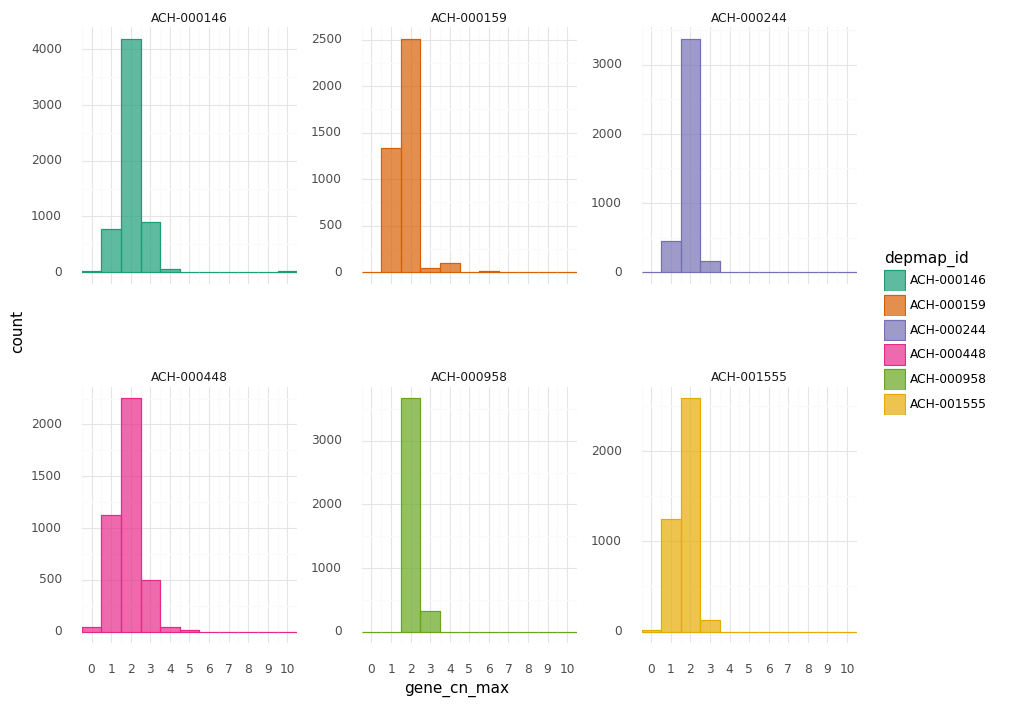

<ggplot: (8749095826089)>

In [53]:
d = modeling_data2.copy()
d["gene_cn_max"] = [np.min((10.0, x)) for x in d.gene_cn]
(
    gg.ggplot(d, gg.aes(x="gene_cn_max"))
    + gg.facet_wrap("depmap_id", scales="free_y")
    + gg.geom_histogram(
        gg.aes(color="depmap_id", fill="depmap_id"), alpha=0.7, binwidth=1.0
    )
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.scale_fill_brewer(type="qual", palette="Dark2")
    + gg.scale_x_continuous(breaks=list(range(12)), expand=(0, 0, 0, 0))
    + gg.theme(figure_size=(10, 8), subplots_adjust={"hspace": 0.4, "wspace": 0.3})
)

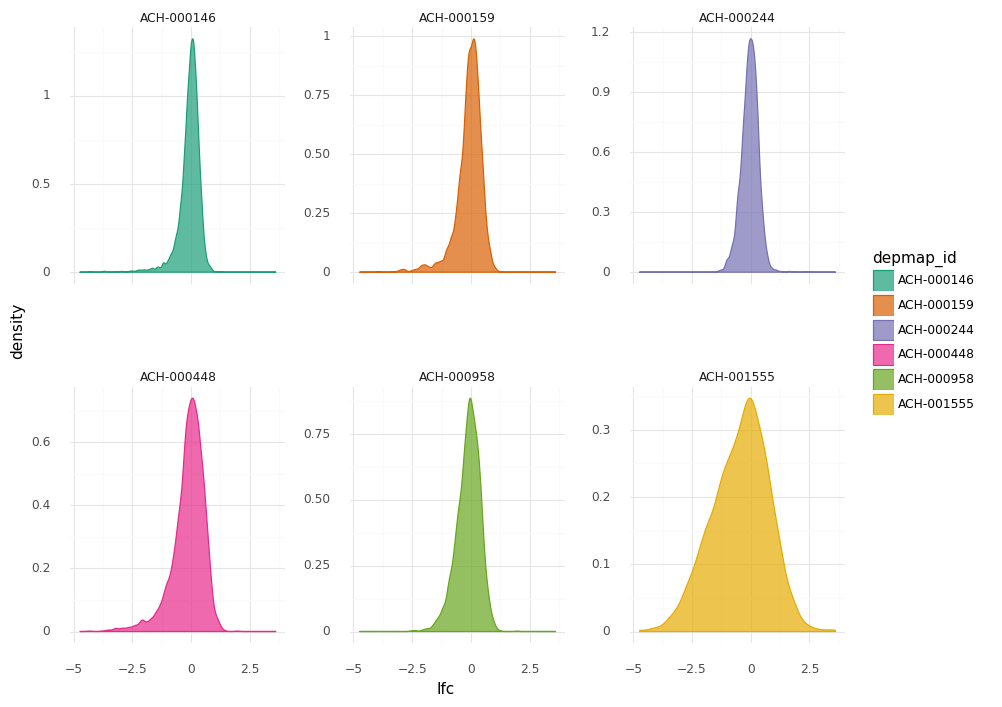

<ggplot: (8749048536869)>

In [54]:
(
    gg.ggplot(d, gg.aes(x="lfc"))
    + gg.facet_wrap("depmap_id", scales="free_y")
    + gg.geom_density(gg.aes(color="depmap_id", fill="depmap_id"), alpha=0.7)
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.scale_fill_brewer(type="qual", palette="Dark2")
    + gg.theme(figure_size=(10, 8), subplots_adjust={"hspace": 0.4, "wspace": 0.3})
)

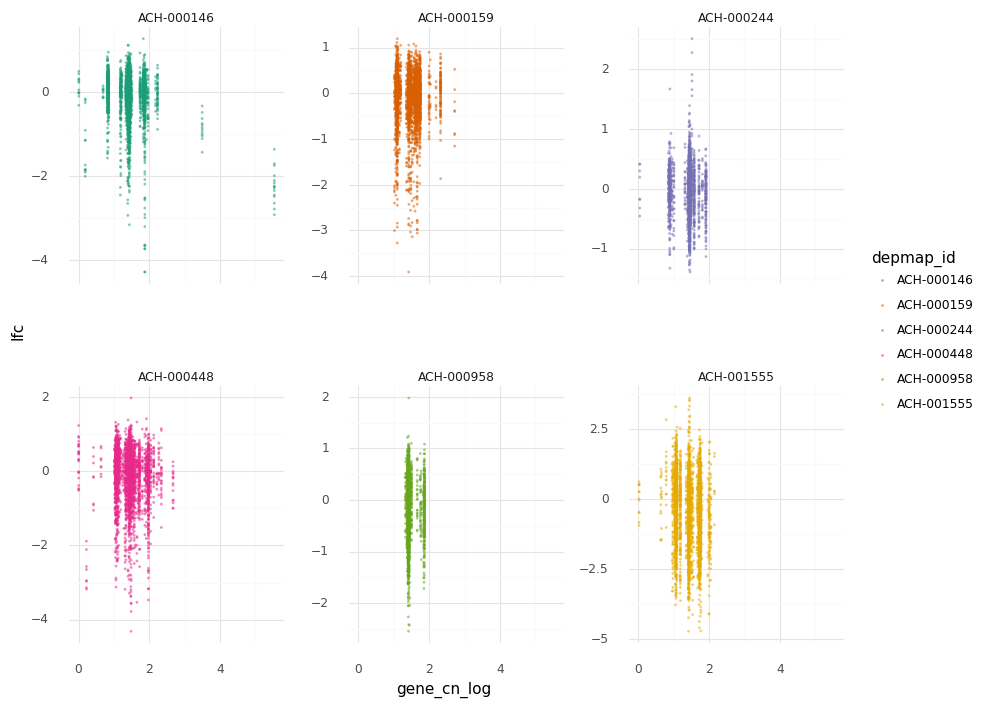

<ggplot: (8749092323615)>

In [55]:
d = modeling_data2.copy()
d["gene_cn_log"] = np.log2(d.gene_cn.values + 1)
(
    gg.ggplot(d, gg.aes(x="gene_cn_log", y="lfc"))
    + gg.facet_wrap("depmap_id", scales="free_y")
    + gg.geom_point(gg.aes(color="depmap_id"), alpha=0.4, size=0.2)
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.scale_fill_brewer(type="qual", palette="Dark2")
    + gg.theme(figure_size=(10, 8), subplots_adjust={"hspace": 0.4, "wspace": 0.3})
)

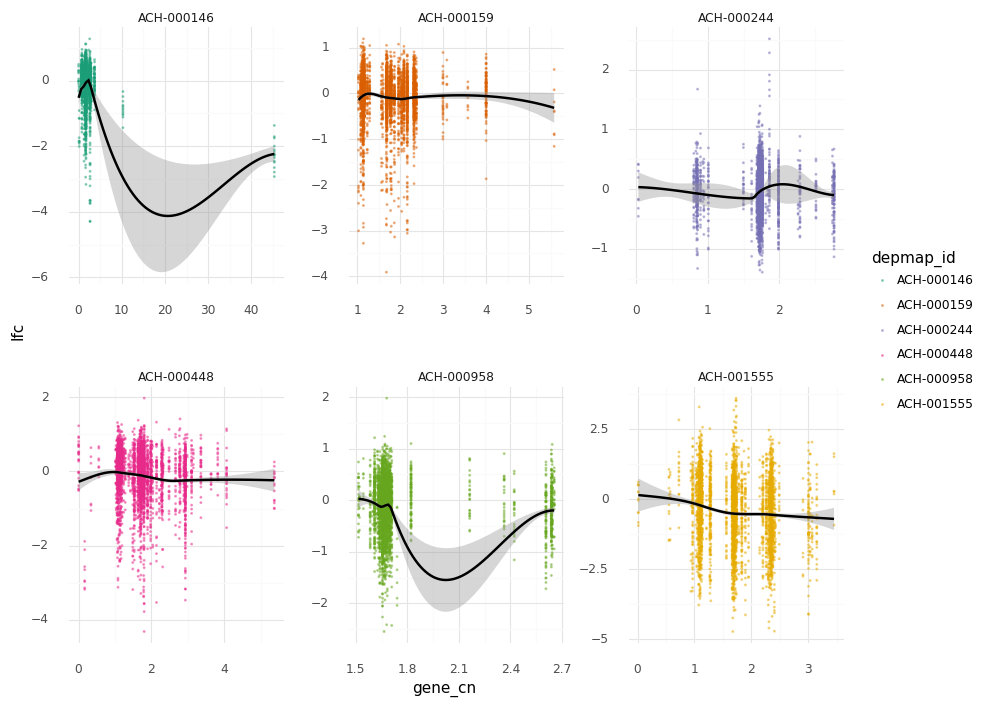

<ggplot: (8749074684760)>

In [56]:
(
    gg.ggplot(d, gg.aes(x="gene_cn", y="lfc"))
    + gg.facet_wrap("depmap_id", scales="free")
    + gg.geom_point(gg.aes(color="depmap_id"), alpha=0.4, size=0.2)
    + gg.geom_smooth(method="loess")
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.scale_fill_brewer(type="qual", palette="Dark2")
    + gg.theme(figure_size=(10, 8), subplots_adjust={"hspace": 0.4, "wspace": 0.3})
)

$
D_j \sim \mathcal{N}(\mu, \sigma) \\
\quad \mu_j = a + B[\text{cell line}] \bullet w[:, \text{cell line}] \\
\qquad a \sim \mathcal{N}(0, 2) \\
\qquad w \sim \mathcal{N}(-0.5, 1) \quad ||w|| = [\text{# knots}, \text{# cell lines}] \\
\quad \sigma \sim \text{Exp}(1)
$

In [57]:
NUM_KNOTS = 10

B_cn_multi = []
for cell_line_i in modeling_data2.depmap_id.cat.categories:

    cell_line_df = modeling_data2.copy()[modeling_data2.depmap_id == cell_line_i]
    cell_line_df = cell_line_df.reset_index(drop=True)

    cell_cn_data = (
        cell_line_df[["depmap_id", "hugo_symbol", "gene_cn"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    knot_list = np.quantile(cell_cn_data.gene_cn, np.linspace(0, 1, NUM_KNOTS))

    B = dmatrix(
        "bs(x, knots=knots, degree=3, include_intercept=True) - 1",
        {"x": cell_line_df.gene_cn, "knots": knot_list[1:-1]},
    )

    B_cn_multi.append(np.asarray(B, order="F"))
# B_cn_multi = np.asarray(B_cn_multi)

In [58]:
for i, B in enumerate(B_cn_multi):
    print(f"B[{i}]: {B.shape[0]}, {B.shape[1]}")

B[0]: 5982, 12
B[1]: 3988, 12
B[2]: 3988, 12
B[3]: 3988, 12
B[4]: 3988, 12
B[5]: 3988, 12


In [59]:
B_cn_multi_idx = []

for i, B in enumerate(B_cn_multi):
    start = int(np.sum([len(x) for x in B_cn_multi[0:i]]))
    length = len(B)
    B_cn_multi_idx.append(np.asarray(range(start, start + length), dtype=int))

B_cn_multi_idx = np.asarray(B_cn_multi_idx)[:, None]
B_cn_multi_idx.dtype

dtype('O')

In [60]:
B_cn_multi_cat = np.concatenate(B_cn_multi)
B_cn_multi_cat.shape

(25922, 12)

*(Original model)*

```python
cell_line_idx = modeling_data2.depmap_id.cat.codes.to_numpy()
w_shape = (NUM_KNOTS + 2, len(np.unique(modeling_data2.depmap_id)))

with pm.Model() as m_cn_multi:
    # Priors
    a = pm.Normal("a", 0, 2)
    w = pm.Normal("w", -0.5, 1, shape=w_shape)

    # Linear model
    mu = pm.Deterministic(
        "mu", a + pm.math.dot(B_cn_multi[cell_line_idx], w[:, cell_line_idx])
    )
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    D = pm.Normal("D", mu, sigma, observed=modeling_data2.lfc)
```

In [62]:
cell_line_idx = modeling_data2.depmap_id.cat.codes.to_numpy()
w_shape = (NUM_KNOTS + 2, len(np.unique(modeling_data2.depmap_id)))

with pm.Model() as m_cn_multi:
    # Priors
    a = pm.Normal("a", 0, 2)
    w = pm.Normal("w", -0.5, 1, shape=w_shape)

    # Linear model
    _mu = a

# Build `mu` for each group.
for cell_line_i in cell_line_idx:
    with m_cn_multi:
        _mu += pm.math.dot(B_cn_multi[cell_line_i], w[:, cell_line_i])

with m_cn_multi:
    mu = pm.Deterministic("mu", _mu)
    sigma = pm.Exponential("sigma", 1)

    # Likelihood
    D = pm.Normal("D", mu, sigma, observed=modeling_data2.lfc)

ValueError: Input dimension mis-match. (input[0].shape[0] = 3988, input[1].shape[0] = 5982)

In [ ]:
pm.model_to_graphviz(m_cn_multi)

*(Used in PyMC3 Discourse question)*

```python
group_idx = d["group"].cat.codes.to_list()
w_shape = (NUM_KNOTS + 2, len(np.unique(d["group"])))

with pm.Model() as m:
    # Priors
    a = pm.Normal("a", 0, 2)
    w = pm.Normal("w", 0, 1, shape=w_shape)
    
    # Linear model
    mu = pm.Deterministic("mu", a + pm.math.dot(B_list[group_idx], w[:, group_idx]))
    sgima = pm.Exponential("sigma", 1)
    
    # Likelihood
    D =  pm.Normal("D", mu, sigma, observed=d["observed_D"])
```

In [25]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

plotnine 0.7.1
pandas   1.1.3
arviz    0.10.0
pymc3    3.9.3
numpy    1.19.2
seaborn  0.11.0
last updated: 2020-11-13 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 28
interpreter: 64bit
host name  : compute-e-16-229.o2.rc.hms.harvard.edu
Git branch : subset-data
